In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from os import pardir

# aliran

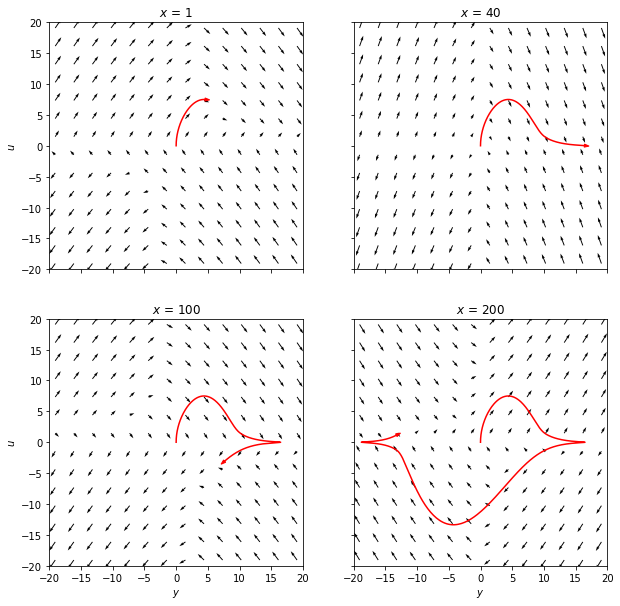

In [95]:
def A(x, y):
    return y*np.sin(x*np.pi/101)
def B(x, y):
    return np.cos(x*np.pi/101)
def velocity(pos, x):
    y, u = pos
    return np.array([u, (B(x, y) - A(x, y)*u)*10])

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for i, (x, ax) in enumerate(zip([1, 40, 100, 200], axes.flatten())):
    y = np.linspace(-22, 22, 16)
    u = np.linspace(-22, 22, 16)
    U, Y = np.meshgrid(u, y)
    u, y = np.ravel(U), np.ravel(Y)
    vel = np.array([velocity([yi, ui], x) for yi, ui in zip(y, u)])
    ydot = vel[:, 0] #.reshape(Y.shape)
    udot = vel[:, 1] #.reshape(U.shape)
    ydot = ydot/np.abs(ydot)*np.abs(ydot)**(1/5)
    udot = udot/np.abs(udot)*np.abs(udot)**(1/5)
    y0 = np.array([0, 0])
    xs = np.linspace(0, x, 10000)
    us = odeint(velocity, y0, xs)
    ax.quiver(y, u, ydot, udot, color="k")
    ax.plot(us[:-1, 0], us[:-1, 1], color="r")
    ax.arrow(us[-2, 0], us[-2, 1], us[-1, 0] - us[-2, 0], us[-1, 1] - us[-2, 1], color="r", head_width=0.5)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_title(r"$x$ = {x}".format(x=x))
    if i in [0, 2]:
        ax.set_ylabel(r"$u$")
    if i in [2, 3]:
        ax.set_xlabel(r"$y$")
fig.savefig(join("img", "diff_eq.pdf"))
    # print(us[:,0])
    # print(velocity([0, 0], 0))
    # break

In [2]:
curr_dir = abspath('')
root_dir = abspath(join(curr_dir, pardir))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/6_Analisis',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir 

'/home2/s20321005/Thesis-Project/Data'

In [6]:
baryon = vaex.open(join(root_data_dir, "Baryon", "baryon.hdf5"))
baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [7]:
rhob = baryon['rho'].to_numpy()
sigmaz = baryon['sigma_z'].to_numpy()

In [11]:
def frho(rho0, phi, sigmaz ):
    return rho0*np.exp(-phi/sigmaz**2)

def rho_tot(phi, rhos, sigmaz, R=3.4E-3):
    rho = np.array(list(map(lambda par: frho(par[0], phi, par[1]), zip(rhos, sigmaz))))
    return rho.sum(axis=0) - R

def velocity(u, z, rho, sigmaz, mu0, mu2, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], (4*np.pi*G*rho_tot(u[0], rho, sigmaz, R) - 2*mu2*z*u[1])/(mu0 + mu2*z**2))

# Aliran

In [9]:
# Test
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zs = np.linspace(0, 400, 1000)

mu0 = 0.64 # Msun/pc^3
mu2 = 1.79e-7 # Msun/pc^2
R = 3.4E-3 # Msun/pc^3
us = odeint(velocity, y0, zs, args=(rhob, sigmaz, mu0, mu2, R))
us_no = odeint(velocity, y0, zs, args=(rhob, sigmaz, mu0, 0, R))

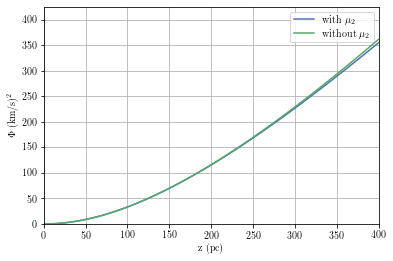

In [37]:
phi = us[:, 0]
phi_no = us_no[:, 0]
plt.plot(zs, phi, label="with $\\mu_2$")
plt.plot(zs, phi_no, label="without $\\mu_2$")
plt.xlabel("z (pc)")
plt.ylabel(r"$\Phi$ (km/s)$^2$")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()
plt.legend()

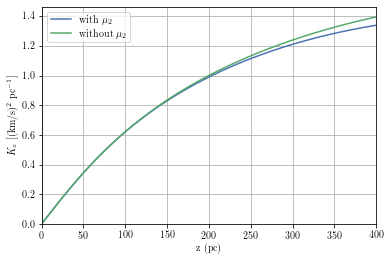

In [38]:
Kz = us[:, 1]
Kz_no = us_no[:, 1]
plt.plot(zs, Kz, label="with $\\mu_2$")
plt.plot(zs, Kz_no, label="without $\\mu_2$")
plt.xlabel("z (pc)")
plt.ylabel(r"$K_z$ [(km/s)$^2$ pc$^{-1}$]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0)
plt.legend()


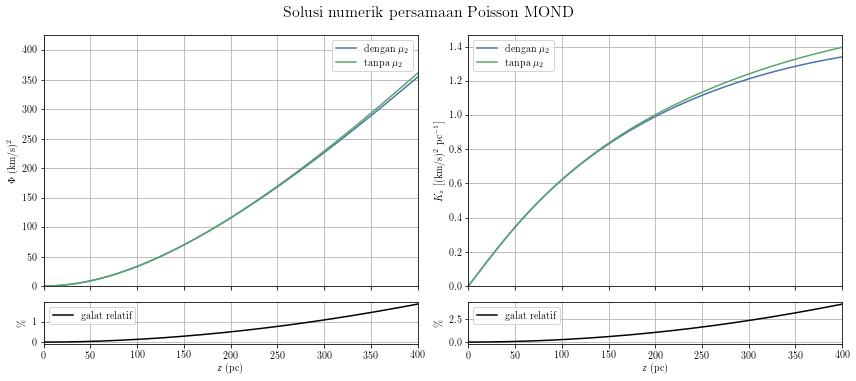

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5), gridspec_kw={'height_ratios': [6, 1]}, sharex=True)
ax[0, 0].plot(zs, phi, label="dengan $\\mu_2$")
ax[0, 0].plot(zs, phi_no, label="tanpa $\\mu_2$")
# ax[0, 0].set_xlabel("z (pc)")
ax[0, 0].set_ylabel(r"$\Phi$ (km/s)$^2$")
ax[0, 0].set_xlim(0, zs[-1])
ax[0, 0].set_ylim(0, phi[-1]*1.2)
ax[0, 0].grid()
ax[0, 0].legend()
ax[1, 0].plot(zs, (phi_no-phi)/phi*100, label="galat relatif", c='k')
ax[1, 0].set_xlabel(r"$z$ (pc)")
ax[1, 0].set_ylabel(r"\%")
ax[1, 0].set_xlim(0, zs[-1])
ax[1, 0].legend()
ax[1,0].grid()
ax[0, 1].plot(zs, Kz, label="dengan $\\mu_2$")
ax[0,1].plot(zs, Kz_no, label="tanpa $\\mu_2$")
# ax[0,1].set_xlabel("z (pc)")
ax[0,1].set_ylabel(r"$K_z$ [(km/s)$^2$ pc$^{-1}$]")
ax[0,1].grid()
ax[0,1].set_xlim(0, zs[-1])
ax[0,1].set_ylim(0)
ax[0,1].legend()
ax[1, 1].plot(zs, (Kz_no-Kz)/Kz*100, label="galat relatif", c='k')
ax[1, 1].set_xlabel(r"$z$ (pc)")
ax[1, 1].set_ylabel(r"\%")
ax[1, 1].set_xlim(0, zs[-1])
ax[1, 1].legend()
ax[1,1].grid()
fig.tight_layout()
fig.suptitle("Solusi numerik persamaan Poisson MOND", y=1.05, fontsize=16)
fig.savefig(join("img", "mond-solve.pdf"), dpi=70)

# prediksi

In [2]:
from hammer import Model